In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import torch
import numpy as np
import random

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [3]:
from personalized_nlp.datasets.emotions.emotions import EmotionsDataModule

In [4]:
emotions_module = EmotionsDataModule(normalize=True)
#emotions_module.prepare_data()
#emotions_module.setup()

## Import models

In [5]:
from personalized_nlp.models.baseline import Net
from personalized_nlp.models.onehot import NetOneHot
from personalized_nlp.models.human_bias import HumanBiasNet
from personalized_nlp.models.bias import AnnotatorBiasNet
from personalized_nlp.models.annotator import AnnotatorEmbeddingNet
from personalized_nlp.models.annotator_word import AnnotatorWordEmbeddingNet

from personalized_nlp.learning.train import train_test
from personalized_nlp.utils.metrics import evaluate_classification, evaluate_regression, get_result_dataframe
from personalized_nlp.settings import STORAGE_DIR

import pickle


In [22]:
model_names_dicts = {
    'baseline': 'Baseline', 
    'onehot': 'OneHot', 
    'peb': 'HuBi-Formula', 
    'bias': 'HuBi-Simple', 
    'embedding': 'HuBi-Medium', 
    'word_embedding': 'HuBi-Complex'
}


language_model_names_dicts = {
    'xlmr': 'XLM-R', 
    'bert': 'BERT', 
    'deberta': 'DeBERTa'
}

## Evaluate

In [63]:
results = []
#results = [r for r in results if r[0]['model_type'] != 'word_embedding']

In [65]:
seed_everything()

regression = True

#for embeddings_type in ['xlmr']:
for embeddings_type in ['xlmr', 'bert', 'deberta']:
    data_module = EmotionsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                    batch_size=1000)
    data_module.prepare_data()
    data_module.setup()
    data_module.compute_word_stats(
        min_word_count=200,
        min_std=0.0,
        words_per_text=100
    )

    for model_type in ['baseline', 'onehot', 'peb', 'bias', 'embedding', 'word_embedding']:
    #for model_type in ['word_embedding']:
        for embedding_dim in [50]:

            #pickle.dump(results, open(STORAGE_DIR / 'results/emotions/emotions_full.p', 'wb'))

            for fold_num in range(1):

                hparams = {
                    'dataset': type(data_module).__name__,
                    'model_type': model_type,
                    'embeddings_type': embeddings_type,
                    'embedding_size': embedding_dim,
                    'fold_num': fold_num,
                    'regression': regression,
                }
                
                output_dim = len(data_module.class_dims)
                text_embedding_dim = data_module.text_embedding_dim
                
                if model_type == 'baseline':
                    model = Net(output_dim=output_dim, text_embedding_dim=text_embedding_dim)
                elif model_type == 'onehot':
                    model = NetOneHot(output_dim=output_dim, annotator_num=data_module.annotators_number, 
                                      text_embedding_dim=text_embedding_dim)
                elif model_type == 'peb':
                    model = HumanBiasNet(output_dim=output_dim, bias_vector_length=len(data_module.class_dims),
                                        text_embedding_dim=text_embedding_dim)
                elif model_type == 'bias':
                    model = AnnotatorBiasNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                             word_num=data_module.words_number, annotator_num=data_module.annotators_number)
                elif model_type == 'embedding':
                    model = AnnotatorEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, word_num=data_module.words_number, 
                                                  annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25, 
                                                  embedding_dim=embedding_dim, hidden_dim=100)
                elif model_type == 'word_embedding':
                    model = AnnotatorWordEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, word_num=data_module.words_number, 
                                                  annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25, 
                                                  embedding_dim=embedding_dim, hidden_dim=100)

                result_dict = train_test(data_module, model, epochs=15, lr=0.008, 
                                                                  experiment_name='default', regression=regression,
                                                                  use_cuda=True, test_fold=fold_num, return_dict=True, test_repetitions=100)
                
                timings = result_dict['times']
                timing_callback = result_dict['timing_callback']
                
                
                results.append((hparams, timings['testing_times']))

/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory ./checkpoints/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 7.7 K 
-------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | NetOneHot | 26.7 M
------------------------------------
59.3 K    Trainable params
26.7 M    Non-trainable params
26.7 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type         | Params
---------------------------------------
0 | model | HumanBiasNet | 7.8 K 
---------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type             | Params
-------------------------------------------
0 | model | AnnotatorBiasNet | 133 K 
-------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | AnnotatorEmbeddingNet | 344 K 
------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | AnnotatorWordEmbeddingNet | 359 K 
----------------------------------------------------
359 K     Trainable params
0         Non-trainable params
359 K     Total params


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory ./checkpoints/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 7.7 K 
-------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | NetOneHot | 26.7 M
------------------------------------
59.3 K    Trainable params
26.7 M    Non-trainable params
26.7 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type         | Params
---------------------------------------
0 | model | HumanBiasNet | 7.8 K 
---------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type             | Params
-------------------------------------------
0 | model | AnnotatorBiasNet | 133 K 
-------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | AnnotatorEmbeddingNet | 344 K 
------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | AnnotatorWordEmbeddingNet | 359 K 
----------------------------------------------------
359 K     Trainable params
0         Non-trainable params
359 K     Total params


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory ./checkpoints/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 10.2 K
-------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | NetOneHot | 26.7 M
------------------------------------
61.9 K    Trainable params
26.7 M    Non-trainable params
26.7 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type         | Params
---------------------------------------
0 | model | HumanBiasNet | 10.3 K
---------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type             | Params
-------------------------------------------
0 | model | AnnotatorBiasNet | 158 K 
-------------------------------------------
158 K     Trainable params
0         Non-trainable params
158 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | AnnotatorEmbeddingNet | 370 K 
------------------------------------------------
370 K     Trainable params
0         Non-trainable params
370 K     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | AnnotatorWordEmbeddingNet | 385 K 
----------------------------------------------------
385 K     Trainable params
0         Non-trainable params
385 K     Total params


## Training time results

In [48]:
from collections import defaultdict
import pandas as pd 

result_dict = defaultdict(list)

for experiment in results:
    hparams = experiment[0]
    metrics = experiment[1]

    for hparam_key, hparam_value in hparams.items():
        result_dict[hparam_key].append(hparam_value)
    
    epoch_stats = metrics.epoch_stats[1:]
    
    best_epoch_idx = np.argmin([es[2] for es in epoch_stats])
    
    result_dict['training_time'].append(epoch_stats[best_epoch_idx][1]) 
    result_dict['best_epoch'].append(best_epoch_idx) 
    
results_df = pd.DataFrame(result_dict)

In [43]:

import pandas as pd 
#results_df.to_csv('/mnt/big_one/persemo/mgruza/personalized_nlp/personalized_nlp/storage/results/emotions/training.times.csv')
results_df = pd.read_csv('/mnt/big_one/persemo/mgruza/personalized_nlp/personalized_nlp/storage/results/emotions/training.times.csv')

results_df['model type'] = results_df['model_type'].apply(model_names_dicts.get)
results_df['embeddings type'] = results_df['embeddings_type'].apply(language_model_names_dicts.get)


In [44]:
results_df#.groupby(['model_type', 'embeddings_type'])#.best_epoch.mean()

,Unnamed: 0,dataset,model_type,embeddings_type,embedding_size,fold_num,regression,training_time,best_epoch,model type,embeddings type
0,0,EmotionsDataModule,baseline,xlmr,50,0,True,3.621014,3,Baseline,XLM-R
1,1,EmotionsDataModule,baseline,xlmr,50,1,True,1.715606,1,Baseline,XLM-R
2,2,EmotionsDataModule,baseline,xlmr,50,2,True,5.206887,5,Baseline,XLM-R
3,3,EmotionsDataModule,baseline,xlmr,50,3,True,10.441497,11,Baseline,XLM-R
4,4,EmotionsDataModule,baseline,xlmr,50,4,True,10.473656,11,Baseline,XLM-R
...,...,...,...,...,...,...,...,...,...,...,...
175,175,EmotionsDataModule,word_embedding,deberta,50,5,True,51.666262,34,HuBi-Complex,DeBERTa
176,176,EmotionsDataModule,word_embedding,deberta,50,6,True,42.688212,28,HuBi-Complex,DeBERTa
177,177,EmotionsDataModule,word_embedding,deberta,50,7,True,50.736526,33,HuBi-Complex,DeBERTa
178,178,EmotionsDataModule,word_embedding,deberta,50,8,True,41.020780,27,HuBi-Complex,DeBERTa


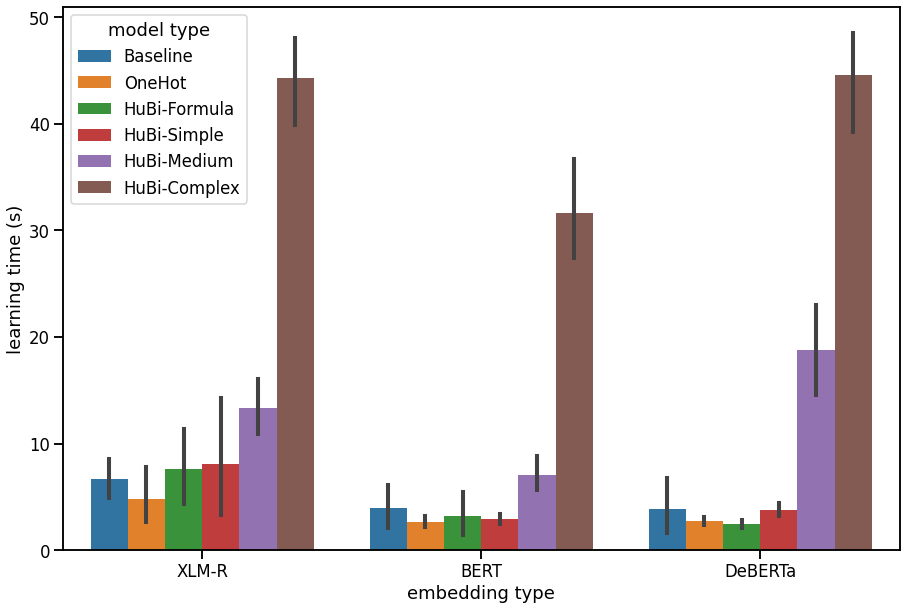

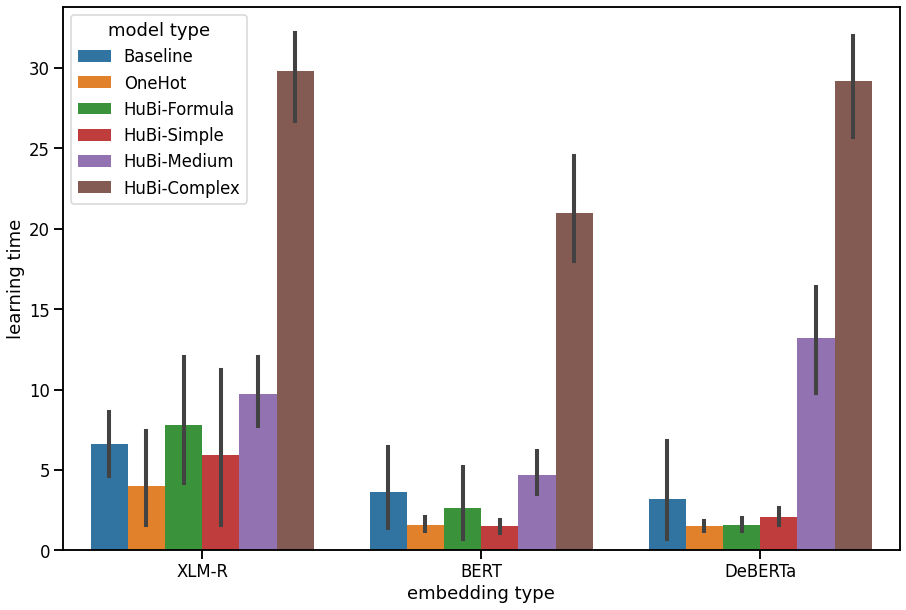

In [45]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model type', y='training_time', x='embeddings type')
plt.ylabel('learning time (s)')
plt.xlabel('embedding type')
plt.savefig('trainig_time_emotions.pdf')

plt.figure(figsize=(15,10))

sns.barplot(data=results_df, hue='model type', y='best_epoch', x='embeddings type')

plt.ylabel('learning time')
plt.xlabel('embedding type')

plt.savefig('')

## Testing time results

In [28]:
from collections import defaultdict
import pandas as pd 

result_dict = defaultdict(list)

for experiment in results:
    hparams = experiment[0]
    testing_times = experiment[1]

    for hparam_key, hparam_value in hparams.items():
        result_dict[hparam_key].append(hparam_value)
    
    result_dict['test_time_mean'].append(np.mean(testing_times)) 
    result_dict['test_time_std'].append(np.std(testing_times)) 
    
results_df = pd.DataFrame(result_dict)

NameError: name 'results' is not defined

In [37]:
#results_df.to_csv('/mnt/big_one/persemo/mgruza/personalized_nlp/personalized_nlp/storage/results/emotions/testing.times.csv')
results_df = pd.read_csv('/mnt/big_one/persemo/mgruza/personalized_nlp/personalized_nlp/storage/results/emotions/testing.times.csv')
results_df['model type'] = results_df['model_type'].apply(model_names_dicts.get)
results_df['embeddings type'] = results_df['embeddings_type'].apply(language_model_names_dicts.get)



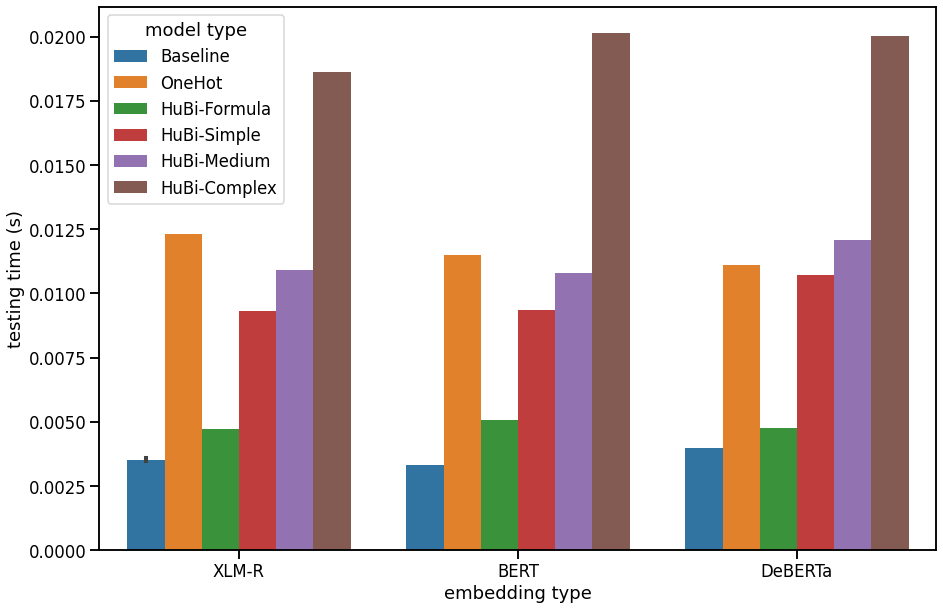

<AxesSubplot:xlabel='embeddings_type', ylabel='test_time_std'>

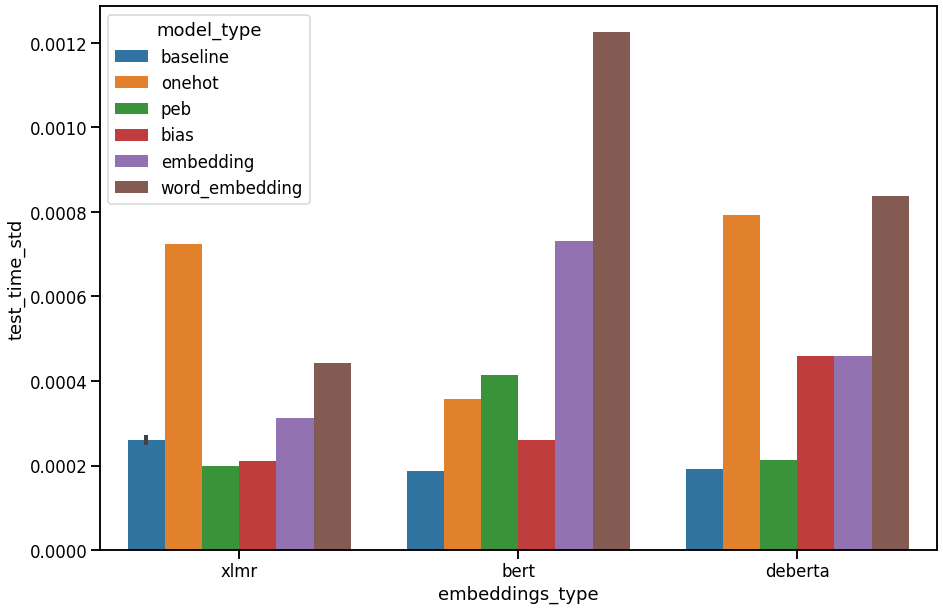

In [39]:
results_df

import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model type', y='test_time_mean', x='embeddings type')
plt.ylabel('testing time (s)')
plt.xlabel('embedding type')
plt.savefig('testing_time_emotions.pdf')
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model_type', y='test_time_std', x='embeddings_type')


## Embedding time

In [94]:
from personalized_nlp.utils.embeddings import create_embeddings

texts = data_module.data[data_module.data.split == 'future2'].text_english.tolist()

for model_name in ['xlm-roberta-base', 'bert-base-cased', 'microsoft/deberta-large']:
    create_embeddings(texts, '', model_name=model_name, use_cuda=True,
                        pickle_embeddings=False)


6it [00:02,  2.73it/s]                          
6it [00:02,  2.76it/s]                          
Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['deberta.embeddings.position_embeddings.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
6it [00:09,  1.57s/it]                          
